In [1]:
import cplex
import numpy as np
import matplotlib as plt
import networkx as nx
import sys
import math
import random
from cplex.exceptions import CplexSolverError
import cplex.callbacks as CPX_CB
from cplex.callbacks import UserCutCallback, LazyConstraintCallback, IncumbentCallback, BranchCallback
from datetime import datetime


In [17]:
class genInput:
    def __init__(self):
        self.N = 0 # num nodes
        self.G = nx.empty_graph()
        #self.nodes = [] #node set
        #self.edges = [] #edge set
        self.bU = 0 #upper budget
        self.bL = 0 #lower budget
        self.cU = [] #upper variable costs
        self.cL = [] #lower variable costs
        self.ciL = [] #lower variable cost increase

    #def initialise_data(self, numnodes:"int", graph_type:"str"="er", p:"float"=0.3, edge_density:"float"=0.2, *args):
    def initialise_data(self, **kwargs): 
        
        inp = {'numnodes':100, 'gtype':"er", 'p':0.3, 'edge_density':0.2, 'ws_param':0.05, 'itemcosts':50, 'budgetprop':0.6, 'test':True}
        for key,value in kwargs.items():
            inp[key] = value

        if inp['test']: 
            inp['numnodes'] = 5
            inp['gtype'] = 'wheel'
        self.N = inp['numnodes']
        if inp['gtype'] == 'er': 
            self.G = nx.erdos_renyi_graph(self.N,inp['p'])
        elif inp['gtype'] == 'ws':
            self.G = nx.empty_graph(inp['numnodes'])
            while not nx.is_connected(self.G):
                print ("GRAPH IS CONNECTED*******:", nx.is_connected(self.G))
                self.G = nx.connected_watts_strogatz_graph(inp['numnodes'],math.ceil(self.N*inp['edge_density']),
                                                           random.normalvariate(inp['p'],inp['ws_param']))
        else:
            self.G = nx.wheel_graph(inp['numnodes'])

        print ("DRAWING GRAPH")
        nx.draw(self.G)

        self.cU = np.random.randint(inp['itemcosts'],inp['itemcosts']*2,self.N)
        self.cL = np.random.randint(inp['itemcosts'],inp['itemcosts']*2,self.N)
        self.cU = list(map(lambda x: int(x), self.cU))
        self.cL = list(map(lambda x: int(x), self.cL))
        self.ciL = list(map(lambda x: x*2, self.cL))
        self.bU = math.ceil(sum(self.cU)*inp['budgetprop'])
        self.bL = math.ceil(sum(self.cL)*inp['budgetprop'])

class MyHeuristic(CPX_CB.HeuristicCallback):
    def __call__(self):
        dbug = self.dbug
        
        node_data = self.get_node_data()
        if self.get_node_ID() % 50 != 0: return
        incum_value = self.get_incumbent_objective_value()
        if dbug: print ("Entering heuristic callback", self.get_node_ID(), self.get_current_node_depth(), incum_value)

        if node_data is None:
            
            lp_yvals = np.array(self.get_values(self.yvars))
            
            subsidy_cost = 0
            
            yvals = [0 for i in range(self.N)]
            
            for i in range(self.N):
                if np.random.random() > lp_yvals[i]: continue #do a randomised rounding on the LP value
                if subsidy_cost + self.cU[i] > self.bU: continue
                yvals[i] = 1
                subsidy_cost += self.cU[i]
            
            cost = list(map(lambda x: self.cL[x] + self.ciL[x]*yvals[x], range(self.N)))#subsidised cost of items - list
            cost_new = cost.copy()
            x_inc = self.x_inc
            u_inc = self.u_inc
            
            self.incmodel.linear_constraints.add(lin_expr = [cplex.SparsePair(ind=x_inc, val=cost)],
                                       senses = ["L"],
                                        rhs = [self.bL], names = ["newcon"])
            for i in range(self.N):
                cost_new[i] += self.bL+1 - cost[i]
                self.incmodel.linear_constraints.add(lin_expr = [cplex.SparsePair(ind= x_inc, val = cost_new)],
                                                     senses = ["G"],
                                                     rhs = [self.bL+1 - cost[i]], names = ["maxcon"+str(i)])
                cost_new[i] += self.bL+1 - cost[i]
            #todo remove this constraint after solve()
            if not dbug: self.incmodel.parameters.mip.display.set(0)
            if not dbug: self.incmodel.set_results_stream(None)
            #if dbug: self.incmodel.write("innerprobHeur.lp")
            self.incmodel.solve()
            if dbug: print ("Solved LL problem", self.incmodel.solution.get_status())
            #self.incmodel.linear_constraints.delete("newCon")
            #todo do early termination to exceed incumbent  value
            
            incmodelObj = self.incmodel.solution.get_objective_value()
            
            if incmodelObj < incum_value - 1e-4: return
            
            #get u values, x values from LL problem and y values from upper level problem
            uvals = []
            solution = self.incmodel.solution
            for i in range(self.N):
                uvals.append([])
                uvals[i] = list(map(lambda x: 1 if x > 1-1e-4 else 0, solution.get_values(self.u_inc[i])))
            
            xvals = list(map(lambda x: 1 if x > 1e-4 else 0, solution.get_values(self.x_inc)))
            zvals = list(map(lambda x: 1 if xvals[x] > 1 - 1e-4 and yvals[x] > 1 - 1e-4 else 0, range(self.N)))
            index = self.xvars + self.yvars + self.zvars
            vals = xvals + yvals + zvals
            for i in range(self.N):
                index += self.uvars[i]
                vals += list(uvals[i])
            
            self.incmodel.linear_constraints.delete("newcon")
            for i in range(self.N):
                self.incmodel.linear_constraints.delete("maxcon"+str(i))
            self.set_solution([index, vals], objective_value = incmodelObj)
        else:
            
            xvals, innerobj, incval, yvals, uvals = node_data
            
            if innerobj <= incum_value - 1e-4: return
            zvals = list(map(lambda x: 1 if xvals[x] > 1 - 1e-4 and yvals[x] > 1 - 1e-4 else 0, range(self.N)))
            #zvals = xvals*yvals
            #
            index = self.xvars + self.yvars + self.zvars
            vals = xvals + yvals + zvals
            
            for i in range(self.N):
                index += self.uvars[i]
                vals += list(uvals[i])
                
            
            self.set_solution([index, vals])

        

class MyBranch(BranchCallback):
    def __call__(self):
        dbug = self.dbug
        if dbug: print ("Entering branching callback", self.get_node_ID(), self.get_current_node_depth())
        node_data = self.get_node_data()
        if node_data is not None:
            xsol, innerobj, incval, yvals, uvals = node_data
        else: 
            return
            
        if dbug: print ("Making branches in branch callback...", xsol, innerobj, incval)

        rhs = self.bL
        ind = []
        val = []
        for x in range(self.N):
            if xsol[x] < 1e-4: continue
            ind += [self.yvars[x]]
            val += [self.ciL[x]*xsol[x]]
            rhs -= self.cL[x]*xsol[x]
           
        index = []
        value = []
        
        #values = [1.0 for i in range(self.N)]
        for x in range(self.N):
            index += self.uvars[x]
            #value += values
            value += self.uobj[x]
        
        #left branch
        #TODO: add the corresponding covercuts here for the left branch
        con = [(cplex.SparsePair(ind = ind, val = val), "G", rhs+1)] #budget based cut
        
        con += [(cplex.SparsePair(ind = index, val = value), "L", incval)] #UB based on rejected incumbent's value
        #Add Nogood cut
        con += [(cplex.SparsePair(ind = self.xvars, 
                                  val = list(map(lambda x: 1.0 if x > 1 - 1e-4 else -1.0, xsol))), "L", sum(xsol) - 1) ]
        #upperbound the objective by incval
        con += [(cplex.SparsePair(ind = index, val= value), "L", incval)]

        self.make_branch(incval, constraints = con)	
        
        #rightbranch
        con = [(cplex.SparsePair(ind = ind, val = val), "L", rhs)]
        
        con += [(cplex.SparsePair(ind = index, val= value), "L", innerobj)]
        self.make_branch(innerobj, constraints = con)	

class MyIncumbent(IncumbentCallback):

    #def __init__(self, env):
    #    super().__init__(env)

    def __call__(self):

        dbug = self.dbug
        if dbug: print ("Entering incumbent callback", self.get_node_ID(), self.get_current_node_depth())
        xvals = list(map(lambda x: 1 if x > 1-1e-4 else 0, self.get_values(self.xvars)))
        yvals = list(map(lambda x: 1 if x > 1-1e-4 else 0, self.get_values(self.yvars)))
        #yvals = np.array(self.get_values(self.yvars))
        
        #zvals = list(map(lambda x: 1 if x > 1-1e-4 else 0, self.get_values(self.zvars)))
        incval =  self.get_objective_value()
        incval1 = self.get_incumbent_objective_value()
        
        cost = list(map(lambda x: self.cL[x] + self.ciL[x]*yvals[x], range(self.N)))#subsidised cost of items - list
        #cost = [self.cL[i] + self.ciL[i]*yvals[i] for i in range(self.N)] #subsidised cost of items - list

        x_inc = self.x_inc
        u_inc = self.u_inc
        
        self.incmodel.linear_constraints.add(lin_expr = [cplex.SparsePair(ind=x_inc, val=cost)],
                                             senses = ["L"],
                                             rhs = [self.bL],
                                             names = ["newcon"])
        #todo remove this constraint after solve()
        if not dbug: self.incmodel.parameters.mip.display.set(0)
        if not dbug: self.incmodel.set_results_stream(None)
        #if dbug: self.incmodel.write("incumlp.lp")
        self.incmodel.solve()
        if dbug: print ("Solved LL problem")
        #self.incmodel.linear_constraints.delete("newCon")
        #todo do early termination to exceed incumbent  value
        incmodelObj = self.incmodel.solution.get_objective_value()
        if dbug: print ("Incumbent rejection check", incmodelObj, incval, incval1 )
        if incmodelObj < incval - 1e-4:
            if incmodelObj > incval1 + 1e-4: #only if innerobj is better than current incumbent value, set noded data
                solution = self.incmodel.solution
                #usol = sum(solution.get_values(self.u_inc))
                #usolution, yvals to be passed to heuristics. Pack them first
                uvals = []
                for i in range(self.N):
                    uvals.append([])
                    uvals[i] = list(map(lambda x: 1 if x > 1-1e-4 else 0, solution.get_values(self.u_inc[i])))
                
                xsol = list(map(lambda x: 1 if x > 1e-4 else 0, solution.get_values(self.x_inc)))
                innerobj = incmodelObj
                self.set_node_data([xsol, innerobj, incval, yvals, uvals])
            #delete the parameterised budget constraint (parametrisation on the y-values set by upper level)
            self.incmodel.linear_constraints.delete("newcon")
            if dbug: print ("Incumbent rejected at callback....")
            #TODO: use the lower level solution to set incumbent (node data that can be used in heuristiccallback)
            self.reject()
        else:
            self.incmodel.linear_constraints.delete("newcon")
            self.accept()
        
class MyCut(UserCutCallback):
    def __call__(self):
        dbug = self.dbug 
        current_node_depth = self.get_current_node_depth()
        if dbug: print ("Entering user cut callback", self.get_node_ID(), current_node_depth)
        if current_node_depth % 10 != 0: return
        G = self.G
        N = self.N
        save_total = self.totcuts
        save_nodedepth = self.nodedepth
        startnode = self.startnode
        numcuts = math.ceil(math.log(current_node_depth) if current_node_depth != 0 else 0)*30
        if save_nodedepth == current_node_depth and save_total >= 200:
            return
        if save_nodedepth != current_node_depth:
            self.nodedepth = current_node_depth
            self.totcuts = 0
            
        #if startnode != 0: print ("Startnode in usercut", startnode,numcuts, current_node_depth)
        attr = {}
        rvals = self.get_values(self.rvars)
        for k,(i,j) in enumerate(G.edges):
            attr[(i,j)] = {'capacity':rvals[k]}
        nx.set_edge_attributes(G, attr)
        totCut = 0
        nodelist = list(range(startnode, N)) + list(range(startnode))
        for t in nodelist:
            uvals = self.get_values(self.uvars[t])
            if totCut > numcuts: break
            for s in range(t+1, N):
                if dbug: print("Running min cut for", s, t)
                cut = nx.minimum_cut(G, s,t)
                if cut[0] < uvals[s] - 1e-4:
                    if dbug: print("cut violation, adding cuts:", cut[0], s,t, uvals[s])
                    nodecutset1 = []
                    nodecutset2 = []
                    nodeval1 = []
                    nodeval2 = []
                    cutset = [self.uvars[s][t]]
                    vals = [-1.0]
                    for k, (i,j) in enumerate(G.edges):
                        if i in cut[1][0] and j in cut[1][1]:
                            cutset += [self.rvars[k]]
                            vals += [1.0]
                            nodecutset1 += [self.xvars[i]]
                            nodecutset2 += [self.xvars[j]]
                            nodeval1 += [1.0]
                            nodeval2 += [1.0]
                        if j in cut[1][0] and i in cut[1][1]:
                            cutset += [self.rvars[k]]
                            vals += [1.0] 
                            nodecutset1 += [self.xvars[j]]
                            nodecutset2 += [self.xvars[i]]
                            nodeval1 += [1.0]
                            nodeval2 += [1.0]
                    if dbug: print ("cutset found", cutset)       
                    self.add(cut=cplex.SparsePair(ind=cutset, val= vals), 
                             sense= "G",
                             rhs = 0)
                    nodeval1 += [1]
                    nodeval2 += [1]
                    for p in cut[1][0]: 
                        for q in cut[1][1]:
                            nodecutset1 += [self.uvars[p][q]]
                            nodecutset2 += [self.uvars[p][q]]
                            self.add(cut=cplex.SparsePair(ind=nodecutset1, val= nodeval1), 
                                     sense= "L",
                                     rhs = len(nodeval1)-1)
                            self.add(cut=cplex.SparsePair(ind=nodecutset2, val= nodeval2), 
                                     sense= "L",
                                     rhs = len(nodeval2)-1)
                            nodecutset1.pop()
                            nodecutset2.pop()
                    totCut += 1
        
        self.startnode = t
        self.totcuts += totCut
            
        if totCut > 0 and dbug: print("Added ", totCut, "cutset cuts")
                

class MyLazy(LazyConstraintCallback):
    """Lazy constraint callback to enforce maximal subsets.
    If used then the callback is invoked for every integer feasible
    solution CPLEX finds. 
    """

    # Callback constructor. Fields 'budgets and costs' are set externally after registering the callback.
    def __init__(self, env):
        super().__init__(env)

    def __call__(self):
        dbug = self.dbug 
        if dbug: print ("Entering lazy callback", self.get_node_ID(), self.get_current_node_depth())
        dbug = self.dbug
        xvals = np.array(self.get_values(self.xvars))
        yvals = np.array(self.get_values(self.yvars))
        zvals = np.array(self.get_values(self.zvars))
        #xvals = list(map(lambda x: 1 if x > 1-1e-4 else 0, self.get_values(self.xvars)))
        #yvals = list(map(lambda x: 1 if x > 1-1e-4 else 0, self.get_values(self.yvars)))
        #zvals = list(map(lambda x: 1 if x > 1-1e-4 else 0, self.get_values(self.zvars)))
        #cost = np.array(self.I.cL) + np.array(self.I.ciL)*yvals
        cost = list(map(lambda x: self.I.cL[x] + self.I.ciL[x]*yvals[x], range(self.I.N)))#subsidised cost of items - list
        #budget = self.I.bL + 1 - np.sum(cost*xvals) #leftover budget
        budget = self.I.bL + 1 - sum(map(lambda x: cost[x]*xvals[x], range(self.I.N))) #leftover budget
    
        #Heuristically generate sets and add cuts
        cutcount = 0
        for i in range(1,self.cutlimit+1):
            if i >= 3 and cutcount/i <= 0.2: break
            if dbug: print ("Entering lazy callback3", i)
            items = list(filter(lambda x: xvals[x] < 1e-4, range(self.I.N))) #items not selected - list
            if dbug: print ("Entering lazy callback4", i, len(items),np.round(xvals,1),yvals)
            random.shuffle(items) #shuffle the list
            if dbug: print ("Entering lazy callback5", i, items, cost, budget)
            cover = []
            costsum = 0
            covercost = 0
            
            for item in items:
                if costsum + cost[item] >= budget: #if the cost of including a non-selected item exceeds the left over budget
                    if dbug: print ("checking cover")
                    if len(cover) == 0: break #cover empty
                    ind, val = [], []
                    for j in range(self.I.N): #add the cut
                        if j in cover:
                            ind += [self.yvars[j]]
                            val += [self.I.ciL[j]]
                        else:
                            ind += [self.xvars[j], self.zvars[j]]
                            val += [self.I.cL[j],self.I.ciL[j]]                           
                    self.add(constraint=cplex.SparsePair(ind = ind, val = val), sense='G', rhs=self.I.bL+1 - covercost)
                    cutcount += 1
                    #print (cover, covercost, costsum, budget, xvals, self.I.bL, yvals, 
                    #        - self.I.bL - 1 + covercost)
                    break
                else:
                    cover += [item]
                    costsum += cost[item]
                    covercost += self.I.cL[item]
                    if dbug: print ("cover,....", cover, costsum)

        #to be implemented
        #if cutcount == 0: do exact separation

        if dbug: print ("Added ", cutcount, " Lazy constraints..........") 

        
    

In [18]:
def biCNDP(**kwargs):
    # Getting the current date and time
    dt = datetime.now()
    heurFlag = 0
    # getting the timestamp
    ts = datetime.timestamp(dt)

    inp = {'numnodes':100, 'gtype':"er", 'p':0.3, 
           'edge_density':0.2, 'ws_param':0.05, 
           'itemcosts':50, 'budgetprop':0.6, 
           'dbug':True, 'test':True, 'ccut':True}
    for key,value in kwargs.items():
            inp[key] = value    
        
    random.seed(ts)
    DBUG = inp['dbug']
    I = genInput()
    I.initialise_data(numnodes=inp['numnodes'], test=inp['test'])
    n=I.N
    ccut = inp['ccut']

    cpx = cplex.Cplex()
    incmodel = cplex.Cplex()
    UB = n
    LB = 0.5
    
    
    
    #Add variables

    x = list(cpx.variables.add(obj = [0]*n,
                               lb = [0]*n,
                               ub = [1]*n,
                               types = ["B"]*n,
                               names = list(map(lambda x: "x[" +str(x)+"]", range(n)))))

    y = list(cpx.variables.add(obj = [0]*n,
                               lb = [0]*n,
                               ub = [1]*n,
                               types = ["B"]*n,
                               names = list(map(lambda x:"y[" + str(x)+"]", range(n)))))
    z = list(cpx.variables.add(obj = [0]*n,
                               lb = [0]*n,
                               ub = [1]*n,
                               types = ["B"]*n,
                               names = list(map(lambda x: "z[" + str(x)+"]", range(n)))))

    x_inc = list(incmodel.variables.add(obj = [0]*n,
                               lb = [0]*n,
                               ub = [1]*n,
                               types = ["B"]*n,
                               names = list(map(lambda x: "x[" + str(x)+"]", range(n)))))
    
    u = list(map(lambda x: [], range(n)))
    u_inc = list(map(lambda x: [], range(n)))
    usol = list(map(lambda x: 0, range(n)))
    usols = []
    uobj = []
    
    for i in range(n):
        usols += [usol]
        obj = [1.0 if j < i else 0 for j in range(n)]
        uobj.append(obj)
        u[i] = list(cpx.variables.add(obj = obj,
                               lb = [0]*n,
                               ub = [1]*n,
                               types = ["B"]*n,
                               names = list(map(lambda x: "u[" + str(x) + "][" + str(i)+"]", range(n)))))

        u_inc[i] = list(incmodel.variables.add(obj = obj,
                               lb = [0]*n,
                               ub = [1]*n,
                               types = ["B"]*n,
                               names = list(map(lambda x: "u[" + str(x) + "][" + str(i)+"]", range(n)))))

    m  = len(I.G.edges)
    r = list(cpx.variables.add(obj = [0]*m,
                               lb = [0]*m,
                               ub = [1]*m,
                               types = ["B"]*m,
                               names = list(map(lambda x: "r[" +str(x)+"]", I.G.edges))))
    
    #print ("Testing ", len([*x, *z]), len(I.cU), len([*I.cL, *I.ciL]))
    cpx.linear_constraints.add(lin_expr = [cplex.SparsePair(ind=y, val = list(I.cU))],
                              senses = ["L"],
                              rhs = [I.bU])

    cpx.linear_constraints.add(lin_expr = [cplex.SparsePair(ind=[*x,*z], val = [*list(I.cL), *list(I.ciL)])],
                              senses = ["L"],
                              rhs = [I.bL])
    #add maximal sets cut
    copy_cL = [i for i in I.cL]
    for i in range(n):
        copy_cL[i] += I.bL+1 - I.cL[i]
        cpx.linear_constraints.add(lin_expr = [cplex.SparsePair(ind=[*x,*z, y[i]], val = [*copy_cL, *list(I.ciL), I.ciL[i]])],
                              senses = ["G"],
                              rhs = [I.bL+1-I.cL[i]])
        copy_cL[i] -= I.bL+1-I.cL[i]
        
        

    for i in range(n):
        cpx.linear_constraints.add(lin_expr = [cplex.SparsePair(ind = [z[i],y[i]], val = [1.0, -1.0])],
                                   senses = ["L"],
                                   rhs = [0.0])
        cpx.linear_constraints.add(lin_expr = [cplex.SparsePair(ind = [z[i],x[i]], val = [1.0, -1.0])],
                                   senses = ["L"],
                                   rhs = [0.0])
        cpx.linear_constraints.add(lin_expr = [cplex.SparsePair(ind = [z[i],x[i], y[i]], val = [-1.0, 1.0, 1.0])],
                                   senses = ["L"],
                                   rhs = [1.0])
                                   
    

    if inp['test']:cpx.linear_constraints.add(lin_expr = [cplex.SparsePair(ind = [y[0]], val = [1])],
                                              senses = ["E"],
                                              rhs = [1.0])
    for k,(i,j) in enumerate(I.G.edges):

        [i,j]= [i,j] if i < j else [j,i]
                    
        cpx.linear_constraints.add(lin_expr = [cplex.SparsePair(ind=[u[i][j],x[i],x[j]], val=[1, 1, 1])],
                                   senses = ["G"],
                                    rhs = [1.0])
        cpx.linear_constraints.add(lin_expr = [cplex.SparsePair(ind=[r[k],x[i]], val=[1, 1])],
                                   senses = ["L"],
                                    rhs = [1.0])
        cpx.linear_constraints.add(lin_expr = [cplex.SparsePair(ind=[r[k],x[j]], val=[1, 1])],
                                   senses = ["L"],
                                    rhs = [1.0])
        cpx.linear_constraints.add(lin_expr = [cplex.SparsePair(ind=[u[i][j],x[i]], val=[1, 1])],
                                   senses = ["L"],
                                    rhs = [1.0])
        cpx.linear_constraints.add(lin_expr = [cplex.SparsePair(ind=[u[i][j],x[j]], val=[1, 1])],
                                   senses = ["L"],
                                    rhs = [1.0])
        incmodel.linear_constraints.add(lin_expr = [cplex.SparsePair(ind=[u_inc[i][j],x_inc[i],x_inc[j]], val=[1, 1, 1])],
                                   senses = ["G"],
                                    rhs = [1.0])
        incmodel.linear_constraints.add(lin_expr = [cplex.SparsePair(ind=[u_inc[i][j],x_inc[i]], val=[1, 1])],
                                   senses = ["L"],
                                    rhs = [1.0])
        incmodel.linear_constraints.add(lin_expr = [cplex.SparsePair(ind=[u_inc[i][j],x_inc[j]], val=[1, 1])],
                                   senses = ["L"],
                                    rhs = [1.0])

        

    for i in range(n):
        for j in range(n):
            if i == j: continue
            cpx.linear_constraints.add(lin_expr = [cplex.SparsePair(ind=[u[i][j],u[j][i]], val=[1, - 1])],
                                   senses = ["E"],
                                    rhs = [0])
            incmodel.linear_constraints.add(lin_expr = [cplex.SparsePair(ind=[u_inc[i][j],u_inc[j][i]], val=[1, - 1])],
                                   senses = ["E"],
                                    rhs = [0])
            for k in range(n):
                if j == k or k==i: continue
                cpx.linear_constraints.add(lin_expr = [cplex.SparsePair(ind=[u[i][j],u[j][k], u[k][i]], val=[1, 1, -1])],
                                   senses = ["L"],
                                    rhs = [1.0])
                cpx.linear_constraints.add(lin_expr = [cplex.SparsePair(ind=[u[i][j],u[j][k], u[k][i]], val=[1, -1, 1])],
                                   senses = ["L"],
                                    rhs = [1.0])
                cpx.linear_constraints.add(lin_expr = [cplex.SparsePair(ind=[u[i][j],u[j][k], u[k][i]], val=[-1, 1, 1])],
                                   senses = ["L"],
                                    rhs = [1.0])

                incmodel.linear_constraints.add(lin_expr = [cplex.SparsePair(ind=[u_inc[i][j],u_inc[j][k], u_inc[k][i]], val=[1, 1, -1])],
                                   senses = ["L"],
                                    rhs = [1.0])
                incmodel.linear_constraints.add(lin_expr = [cplex.SparsePair(ind=[u_inc[i][j],u_inc[j][k], u_inc[k][i]], val=[1, -1, 1])],
                                   senses = ["L"],
                                    rhs = [1.0])
                incmodel.linear_constraints.add(lin_expr = [cplex.SparsePair(ind=[u_inc[i][j],u_inc[j][k], u_inc[k][i]], val=[-1, 1, 1])],
                                   senses = ["L"],
                                    rhs = [1.0])

    xsol = list(map(lambda x: 0, range(I.N)))
    cpx.objective.set_sense(cpx.objective.sense.maximize)

    cpx.write("biCNDP.lp")
    #cpx.set_results_stream(resFile)
    #cpx.parameters.preprocessing.reduce.set(0)
    #cpx.parameters.preprocessing.presolve.set(0)
    cpx.parameters.mip.tolerances.mipgap.set(0.05)
    
    #cpx.parameters.mip.strategy.probe.set(2)
    #cpx.parameters.emphasis.mip.set(0)
    #cpx.parameters.mip.strategy.dive.set(2)
    #cpx.parameters.mip.strategy.bbinterval.set(5)
    #cpx.parameters.mip.display.set(4)
    cpx.parameters.timelimit.set(3600)
    #cpx.parameters.threads.set(1)
    #cpx.parameters.mip.strategy.backtrack.set(0.01)
    '''lazycb = cpx.register_callback(MyLazy)
    lazycb.I = I
    lazycb.dbug = DBUG
    lazycb.xvars = x
    lazycb.yvars = y
    lazycb.zvars = z
    lazycb.cutlimit = 30
    lazycb.xsol = xsol
    lazycb.usol = usols
    '''

    if ccut:
        usercb = cpx.register_callback(MyCut)
        usercb.rvars = r
        usercb.uvars = u
        usercb.xvars = x
        usercb.G = I.G.copy()
        usercb.N = I.N
        usercb.dbug = DBUG
        usercb.startnode = 0
        usercb.nodedepth = 0
        usercb.totcuts = 0
    
    
    inccb = cpx.register_callback(MyIncumbent)
    inccb.incmodel = incmodel
    inccb.dbug = DBUG
    inccb.x_inc = x_inc
    inccb.u_inc = u_inc
    inccb.ciL = I.ciL
    inccb.cL = I.cL
    inccb.bL = I.bL
    inccb.N = I.N
    inccb.xvars = x
    inccb.yvars = y
    inccb.xsol = xsol
    inccb.usol = usols
    inccb.innerobj = 0
    
    brcb = cpx.register_callback(MyBranch)
    brcb.dbug = DBUG
    brcb.yvars = y
    brcb.xvars = x
    brcb.uvars = u
    brcb.ciL = I.ciL
    brcb.cL = I.cL
    brcb.bL = I.bL
    brcb.N  = n
    brcb.uobj = uobj
    
    #lazycb.cU = I.cU
    #lazycb.cL = I.cL
    #lazycb.bU = I.bU
    #lazycb.bL = I.bL
    #lazycb.ciL = I.ciL

    #usercb = cpx.register_callback(MyCut)
    #usercb = x
    #usercb = u
    
    #cpx.register_callback(MyIncumbent)
    heurcb = cpx.register_callback(MyHeuristic)
    heurcb.xvars = x
    heurcb.dbug = DBUG
    heurcb.yvars = y
    heurcb.zvars = z
    heurcb.uvars = u
    heurcb.incmodel = incmodel
    heurcb.x_inc = x_inc
    heurcb.u_inc = u_inc
    heurcb.N = I.N
    heurcb.ciL = I.ciL
    heurcb.cL = I.cL
    
    heurcb.bL = I.bL
    heurcb.N = I.N
    heurcb.cU = I.cU
    heurcb.bU = I.bU
    #cpx.register_callback(MyCut)
    #cpx.register_callback(MyBranch)

    cpx.solve()
    solution = cpx.solution
    mip = solution.MIP
    progress = solution.progress
    xvals = solution.get_values(x)
    yvals = solution.get_values(y)
    zvals = solution.get_values(z)
    print ("Total xvars picked", xvals, yvals, zvals)
    obj = cpx.solution.get_objective_value()
    print ("objective:", obj, mip.get_mip_relative_gap())



DRAWING GRAPH


Default row names c1, c2 ... being created.


Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
CPXPARAM_TimeLimit                               3600
CPXPARAM_MIP_Tolerances_MIPGap                   0.050000000000000003
Legacy callback                                  BbUHID


         Disabling repeat represolve because of lazy constraint/incumbent callback.
Tried aggregator 2 times.
Detecting symmetries...
MIP Presolve eliminated 295953 rows and 414 columns.
MIP Presolve modified 100 coefficients.
Aggregator did 1225 substitutions.
Reduced MIP has 60094 rows, 1375 columns, and 184498 nonzeros.
Reduced MIP has 1375 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 1.74 sec. (530.34 ticks)
Probing time = 0.01 sec. (4.82 ticks)
Clique table members: 1068.
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 12.00 sec. (1032.48 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variable B NodeID Parent  Depth

      0     0     1097.7432  1375                   1097.7432       23         
*     0+    0                          325.00

Advanced basis not built.



Root node processing (before b&c):
  Real time             = 4641.08 sec. (2590.23 ticks)
Sequential b&c:
  Real time             =    0.00 sec. (0.00 ticks)
                          ------------
Total (root+branch&cut) = 4641.08 sec. (2590.23 ticks)
Total xvars picked [1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0] [0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0] [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

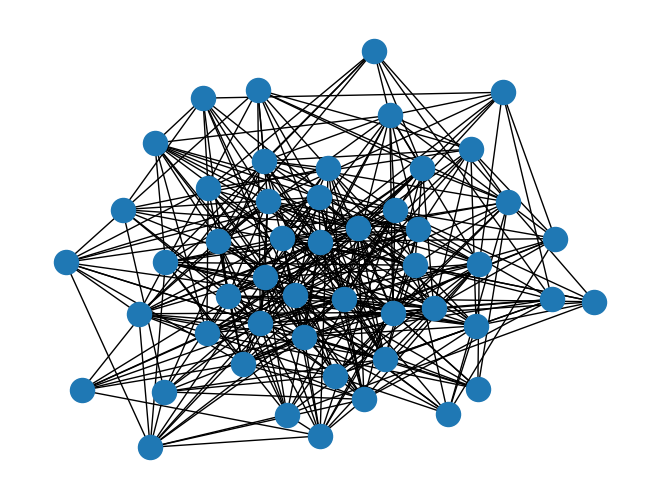

In [20]:
biCNDP(numnodes=50, dbug=False, test=False, ccut=True)

GRAPH IS CONNECTED*******: False


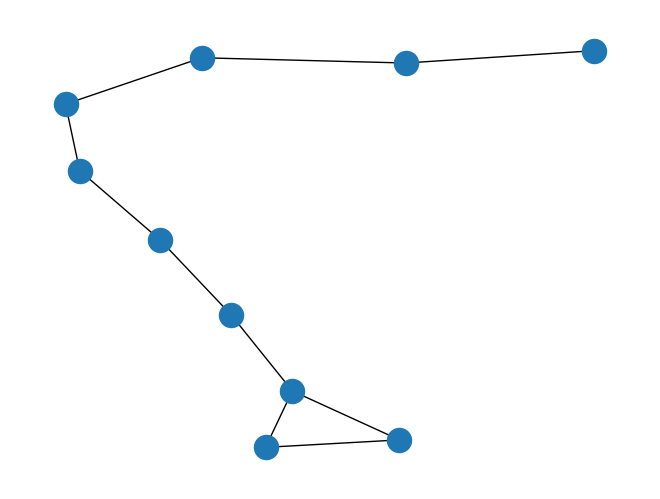

In [63]:
n=10
G = nx.empty_graph(n)
while not nx.is_connected(G):
    print ("GRAPH IS CONNECTED*******:", nx.is_connected(G))
    G = nx.connected_watts_strogatz_graph(n,math.ceil(n*0.2),
                                               random.normalvariate(0.3,0.05))
nx.draw(G)

In [14]:
a = list(range(5))
a.pop()
a.pop()
print(a)

[0, 1, 2]


In [21]:
import subprocess
subprocess.check_call(['python', '-m', 'pip', 'install','pandas_datareader'])
subprocess.check_call([b'python', '-m', 'pip', 'install','yfinance'])

DEPRECATION: xpress 9.0.3 has a non-standard dependency specifier numpy<1.24,>=invalid_numpy_version. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of xpress or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


DEPRECATION: xpress 9.0.3 has a non-standard dependency specifier numpy<1.24,>=invalid_numpy_version. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of xpress or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


0

In [28]:
from pandas_datareader import data import yfinance as yf
yf.pdr_override()
apl_yahoo = data.DataReader('AAPL', '2000-1-1')
apl_yahoo.info()

[*********************100%***********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6229 entries, 2000-01-03 to 2024-10-04
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       6229 non-null   float64
 1   High       6229 non-null   float64
 2   Low        6229 non-null   float64
 3   Close      6229 non-null   float64
 4   Adj Close  6229 non-null   float64
 5   Volume     6229 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 340.6 KB


In [27]:
apl_yahoo

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,0.936384,1.004464,0.907924,0.999442,0.844004,535796800
2000-01-04,0.966518,0.987723,0.903460,0.915179,0.772846,512377600
2000-01-05,0.926339,0.987165,0.919643,0.928571,0.784155,778321600
2000-01-06,0.947545,0.955357,0.848214,0.848214,0.716295,767972800
2000-01-07,0.861607,0.901786,0.852679,0.888393,0.750226,460734400
...,...,...,...,...,...,...
2024-09-30,230.039993,233.000000,229.649994,233.000000,233.000000,54541900
2024-10-01,229.520004,229.649994,223.740005,226.210007,226.210007,63285000
2024-10-02,225.889999,227.369995,223.020004,226.779999,226.779999,32880600
